In [1]:
from brian2 import *

import plot_utils as pu

set_device('cpp_standalone', directory=None)  # Use fast "C++ standalone mode"
seed(28371)  # to get identical figures for repeated runs


# Model parameters
### General parameters
N_e = 3200                   # Number of excitatory neurons
N_i = 800                    # Number of inhibitory neurons
N_a = 3200                   # Number of astrocytes

## Some metrics parameters needed to establish proper connections
size = 3.75*mmeter           # Length and width of the square lattice
distance = 50*umeter         # Distance between neurons

### Neuron parameters
E_l = -60*mV                 # Leak reversal potential
g_l = 9.99*nS                # Leak conductance
E_e = 0*mV                   # Excitatory synaptic reversal potential
E_i = -80*mV                 # Inhibitory synaptic reversal potential
C_m = 198*pF                 # Membrane capacitance
tau_e = 5*ms                 # Excitatory synaptic time constant
tau_i = 10*ms                # Inhibitory synaptic time constant
tau_r = 5*ms                 # Refractory period
I_ex = 100*pA                # External current
V_th = -50*mV                # Firing threshold
V_r = E_l                    # Reset potential

### Synapse parameters
rho_c = 0.005                # Synaptic vesicle-to-extracellular space volume ratio
Y_T = 500.*mmolar            # Total vesicular neurotransmitter concentration
Omega_c = 40/second          # Neurotransmitter clearance rate
U_0__star = 0.6              # Resting synaptic release probability
Omega_f = 3.33/second        # Synaptic facilitation rate
Omega_d = 2.0/second         # Synaptic depression rate
w_e = 0.05*nS                # Excitatory synaptic conductance
w_i = 1.0*nS                 # Inhibitory synaptic conductance
# --- Presynaptic receptors
O_G = 1.5/umolar/second      # Agonist binding (activating) rate
Omega_G = 0.5/(60*second)    # Agonist release (deactivating) rate

### Astrocyte parameters
# ---  Calcium fluxes
O_P = 0.9*umolar/second      # Maximal Ca^2+ uptake rate by SERCAs
K_P = 0.05*umolar            # Ca2+ affinity of SERCAs
C_T = 2*umolar               # Total cell free Ca^2+ content
rho_A = 0.18                 # ER-to-cytoplasm volume ratio
Omega_C = 6/second           # Maximal rate of Ca^2+ release by IP_3Rs
Omega_L = 0.1/second         # Maximal rate of Ca^2+ leak from the ER
# --- IP_3R kinectics
d_1 = 0.13*umolar            # IP_3 binding affinity
d_2 = 1.05*umolar            # Ca^2+ inactivation dissociation constant
O_2 = 0.2/umolar/second      # IP_3R binding rate for Ca^2+ inhibition
d_3 = 0.9434*umolar          # IP_3 dissociation constant
d_5 = 0.08*umolar            # Ca^2+ activation dissociation constant
# --- IP_3 production
# --- Agonist-dependent IP_3 production
O_beta = 0.5*umolar/second   # Maximal rate of IP_3 production by PLCbeta
O_N = 0.3/umolar/second      # Agonist binding rate
Omega_N = 0.5/second         # Maximal inactivation rate
K_KC = 0.5*umolar            # Ca^2+ affinity of PKC
zeta = 10                    # Maximal reduction of receptor affinity by PKC
# --- Endogenous IP3 production
O_delta = 1.2*umolar/second  # Maximal rate of IP_3 production by PLCdelta
kappa_delta = 1.5*umolar     # Inhibition constant of PLC_delta by IP_3
K_delta = 0.1*umolar         # Ca^2+ affinity of PLCdelta
# --- IP_3 degradation
Omega_5P = 0.05/second       # Maximal rate of IP_3 degradation by IP-5P
K_D = 0.7*umolar             # Ca^2+ affinity of IP3-3K
K_3K = 1.0*umolar            # IP_3 affinity of IP_3-3K
O_3K = 4.5*umolar/second     # Maximal rate of IP_3 degradation by IP_3-3K
# --- IP_3 diffusion
F = 0.09*umolar/second       # GJC IP_3 permeability
I_Theta = 0.3*umolar         # Threshold gradient for IP_3 diffusion
omega_I = 0.05*umolar        # Scaling factor of diffusion
# --- Gliotransmitter release and time course
C_Theta = 0.5*umolar         # Ca^2+ threshold for exocytosis
Omega_A = 0.6/second         # Gliotransmitter recycling rate
U_A = 0.6                    # Gliotransmitter release probability
G_T = 200*mmolar             # Total vesicular gliotransmitter concentration
rho_e = 6.5e-4               # Astrocytic vesicle-to-extracellular volume ratio
Omega_e = 60/second          # Gliotransmitter clearance rate
alpha = 0.0                  # Gliotransmission nature



In [2]:

# Define HF stimulus

stimulus = TimedArray([1.0, 1.2, 1.0, 1.0], dt=2*second)

# Simulation time (based on the stimulus)

duration = 8*second          # Total simulation time


# Model definition
# 1) st part
### Neurons
neuron_eqs = '''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) + I_ex*stimulus(t))/C_m : volt (unless refractory)
dg_e/dt = -g_e/tau_e : siemens  # post-synaptic excitatory conductance
dg_i/dt = -g_i/tau_i : siemens  # post-synaptic inhibitory conductance
# Neuron position in space
x : meter (constant)
y : meter (constant)
'''
neurons = NeuronGroup(N_e + N_i, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')
exc_neurons = neurons[:N_e]
inh_neurons = neurons[N_e:]
# Arrange excitatory neurons in a grid
N_rows = int(sqrt(N_e))
N_cols = N_e/N_rows
grid_dist = (size / N_cols)
exc_neurons.x = '(i / N_rows)*grid_dist - N_rows/2.0*grid_dist'
exc_neurons.y = '(i % N_rows)*grid_dist - N_cols/2.0*grid_dist'
# Random initial membrane potential values and conductances
neurons.v = 'E_l + rand()*(V_th-E_l)'
neurons.g_e = 'rand()*w_e'
neurons.g_i = 'rand()*w_i'

In [3]:
# Synapses - 2nd part
synapses_eqs = '''
# Neurotransmitter
dY_S/dt = -Omega_c * Y_S                                    : mmolar (clock-driven)
# Fraction of activated presynaptic receptors
dGamma_S/dt = O_G * G_A * (1 - Gamma_S) - Omega_G * Gamma_S : 1 (clock-driven)
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S                                    : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available for release:
dx_S/dt = Omega_d *(1 - x_S)                                : 1 (event-driven)
U_0                                                         : 1
# released synaptic neurotransmitter resources:
r_S                                                         : 1
# gliotransmitter concentration in the extracellular space:
G_A                                                         : mmolar
# which astrocyte covers this synapse ?
astrocyte_index : integer (constant)
'''
synapses_action = '''
U_0 = (1 - Gamma_S) * U_0__star + alpha * Gamma_S
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
Y_S += rho_c * Y_T * r_S
'''
exc_syn = Synapses(exc_neurons, neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S',
                   method='linear')
exc_syn.connect(True, p=0.05)
exc_syn.x_S = 1.0
inh_syn = Synapses(inh_neurons, neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_i_post += w_i*r_S',
                   method='linear')
inh_syn.connect(True, p=0.2)
inh_syn.x_S = 1.0
# Connect excitatory synapses to an astrocyte depending on the position of the
# post-synaptic neuron
N_rows_a = int(sqrt(N_a))
N_cols_a = N_a/N_rows_a
grid_dist = size / N_rows_a
exc_syn.astrocyte_index = ('int(x_post/grid_dist) + '
                           'N_cols_a*int(y_post/grid_dist)')

In [4]:
# Astrocytes definition part
### Astrocytes
astro_eqs = '''
# Fraction of activated astrocyte receptors:
dGamma_A/dt = O_N * Y_S * (1 - clip(Gamma_A,0,1)) -
              Omega_N*(1 + zeta * C/(C + K_KC)) * clip(Gamma_A,0,1) : 1
# Intracellular IP_3
dI/dt = J_beta + J_delta - J_3K - J_5P + J_coupling              : mmolar
J_beta = O_beta * Gamma_A                                        : mmolar/second
J_delta = O_delta/(1 + I/kappa_delta) * C**2/(C**2 + K_delta**2) : mmolar/second
J_3K = O_3K * C**4/(C**4 + K_D**4) * I/(I + K_3K)                : mmolar/second
J_5P = Omega_5P*I                                                : mmolar/second
# Diffusion between astrocytes:
J_coupling                                                       : mmolar/second

# Ca^2+-induced Ca^2+ release:
dC/dt = J_r + J_l - J_p                                   : mmolar
dh/dt = (h_inf - h)/tau_h                                 : 1
J_r = (Omega_C * m_inf**3 * h**3) * (C_T - (1 + rho_A)*C) : mmolar/second
J_l = Omega_L * (C_T - (1 + rho_A)*C)                     : mmolar/second
J_p = O_P * C**2/(C**2 + K_P**2)                          : mmolar/second
m_inf = I/(I + d_1) * C/(C + d_5)                         : 1
h_inf = Q_2/(Q_2 + C)                                     : 1
tau_h = 1/(O_2 * (Q_2 + C))                               : second
Q_2 = d_2 * (I + d_1)/(I + d_3)                           : mmolar

# Fraction of gliotransmitter resources available for release:
dx_A/dt = Omega_A * (1 - x_A) : 1
# gliotransmitter concentration in the extracellular space:
dG_A/dt = -Omega_e*G_A        : mmolar
# Neurotransmitter concentration in the extracellular space:
Y_S                           : mmolar
# The astrocyte position in space
x : meter (constant)
y : meter (constant)
'''
glio_release = '''
G_A += rho_e * G_T * U_A * x_A
x_A -= U_A *  x_A
'''
astrocytes = NeuronGroup(N_a, astro_eqs,
                         # The following formulation makes sure that a "spike" is
                         # only triggered at the first threshold crossing
                         threshold='C>C_Theta',
                         refractory='C>C_Theta',
                         # The gliotransmitter release happens when the threshold
                         # is crossed, in Brian terms it can therefore be
                         # considered a "reset"
                         reset=glio_release,
                         method='rk4',
                         dt=1e-2*second)
# Arrange astrocytes in a grid
astrocytes.x = '(i / N_rows_a)*grid_dist - N_rows_a/2.0*grid_dist'
astrocytes.y = '(i % N_rows_a)*grid_dist - N_cols_a/2.0*grid_dist'
# Add random initialization
astrocytes.C = 0.01*umolar
astrocytes.h = 0.9
astrocytes.I = 0.01*umolar
astrocytes.x_A = 1.0
# Astrocytes to synapse and synapse to astrocytes
ecs_astro_to_syn = Synapses(astrocytes, exc_syn,
                            'G_A_post = G_A_pre : mmolar (summed)')
ecs_astro_to_syn.connect('i == astrocyte_index_post')
ecs_syn_to_astro = Synapses(exc_syn, astrocytes,
                            'Y_S_post = Y_S_pre/N_incoming : mmolar (summed)')
ecs_syn_to_astro.connect('astrocyte_index_pre == j')
# Diffusion between astrocytes
astro_to_astro_eqs = '''
delta_I = I_post - I_pre            : mmolar
J_coupling_post = -(1 + tanh((abs(delta_I) - I_Theta)/omega_I))*
                  sign(delta_I)*F/2 : mmolar/second (summed)
'''
astro_to_astro = Synapses(astrocytes, astrocytes,
                          model=astro_to_astro_eqs)
# Connect to all astrocytes less than 75um away
# (about 4 connections per astrocyte)
# network of astrocytes
astro_to_astro.connect('i != j and '
                       'sqrt((x_pre-x_post)**2 +'
                       '     (y_pre-y_post)**2) < 75*um')


# Monitors
################################################################################
# Note that we could use a single monitor for all neurons instead, but this
# way plotting is a bit easier in the end
exc_mon = SpikeMonitor(exc_neurons)
inh_mon = SpikeMonitor(inh_neurons)
ast_mon = SpikeMonitor(astrocytes)

################################################################################
# Simulation run
################################################################################
run(duration, report='text')

Starting simulation at t=0 s for duration 8 s
0.0913 s (1%) simulated in 10s, estimated 14m 27s remaining.
0.1828 s (2%) simulated in 20s, estimated 14m 15s remaining.
0.2743 s (3%) simulated in 30s, estimated 14m 5s remaining.
0.3657 s (4%) simulated in 40s, estimated 13m 55s remaining.
0.4571 s (5%) simulated in 50s, estimated 13m 45s remaining.
0.5484 s (6%) simulated in 1m 0s, estimated 13m 35s remaining.
0.6399 s (7%) simulated in 1m 10s, estimated 13m 25s remaining.
0.7312 s (9%) simulated in 1m 20s, estimated 13m 15s remaining.
0.8227 s (10%) simulated in 1m 30s, estimated 13m 5s remaining.
0.9141 s (11%) simulated in 1m 40s, estimated 12m 55s remaining.
1.0055 s (12%) simulated in 1m 50s, estimated 12m 45s remaining.
1.0969 s (13%) simulated in 2m 0s, estimated 12m 35s remaining.
1.1883 s (14%) simulated in 2m 10s, estimated 12m 25s remaining.
1.2798 s (15%) simulated in 2m 20s, estimated 12m 15s remaining.
1.3713 s (17%) simulated in 2m 30s, estimated 12m 5s remaining.
1.4627 

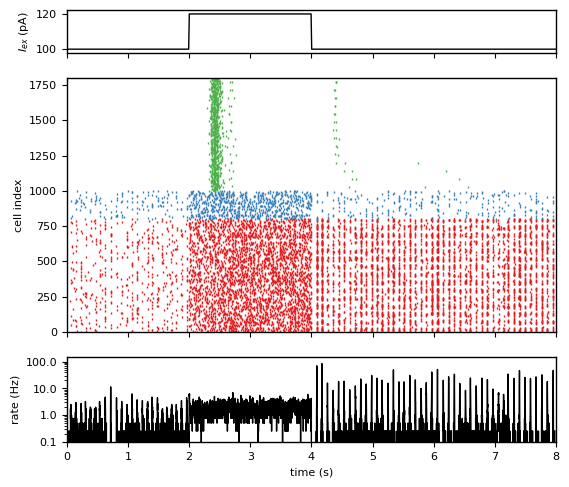

In [10]:
################################################################################
# Plot of Spiking activity
################################################################################
plt.style.use('figures.mplstyle')

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6.26894, 6.26894*0.8),
                       gridspec_kw={'height_ratios': [1, 6, 2],
                                    'left': 0.12, 'top': 0.97})
time_range = np.linspace(0, 8, 8*100)*second
ax[0].plot(time_range, I_ex*stimulus(time_range)/pA, 'k')
ax[0].set(xlim=(0, duration/second), ylim=(98, 122),
          yticks=[100, 120], ylabel='$I_{ex}$ (pA)')

## We only plot a fraction of the spikes
fraction = 4
ax[1].plot(exc_mon.t[exc_mon.i <= N_e//fraction]/second,
           exc_mon.i[exc_mon.i <= N_e//fraction], '|', color='C0')
ax[1].plot(inh_mon.t[inh_mon.i <= N_i//fraction]/second,
           inh_mon.i[inh_mon.i <= N_i//fraction]+N_e//fraction, '|', color='C1')
ax[1].plot(ast_mon.t[ast_mon.i <= N_a//fraction]/second,
           ast_mon.i[ast_mon.i <= N_a//fraction]+(N_e+N_i)//fraction,
           '|', color='C2')
ax[1].set(xlim=(0, duration/second), ylim=[0,(N_e+N_i+N_a)//fraction],
          yticks=np.arange(0, (N_e+N_i+N_a)//fraction+1, 250),
          ylabel='cell index')

# Generate frequencies
bin_size = 1*ms
spk_count, bin_edges = np.histogram(np.r_[exc_mon.t/second, inh_mon.t/second],
                                    int(duration/bin_size))
rate = 1.0*spk_count/(N_e + N_i)/bin_size/Hz
rate[rate<0.001] = 0.001 # Fix 0 lower bound for log scale
ax[2].semilogy(bin_edges[:-1], rate, '-', color='k')
ax[2].set(xlim=(0, duration/second), ylim=(0.1, 150),
          xticks=np.arange(0,9), yticks=[0.1, 1, 10, 100],
          xlabel='time (s)', ylabel='rate (Hz)')
ax[2].get_yaxis().set_major_formatter(ScalarFormatter())


plt.show()